# Deep learning lab
*By Ebba Bergman*


Welcome to this Deep Learning notebook!

Today we are going to go Start with an Artificial Neural Network (ANN) and then move on to a Convolutional Neural Network (CNN)

Your task today is to make a network that can categorise bloodcells from the  [Human White Blood Cells (BBBC045v1)](https://bbbc.broadinstitute.org/BBBC045) dataset from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012]. 

First you will get some networks to try, and then some new techniques that you will apply to try and improve this network. Try several things, and try to understand what the new techniques could improve. Reflect to see if you can see these improvements in this case. *Note: It's not always easy to know from the start what will work, a lot of developing neural networks can feel like qualified guess work. **Qualified** being the key word.*

Also take this opportunity to try to understand the code, you may be able to reuse some of it for your assignment in Deep Learning. There will be questions throughout to give you things to consider, but **no hand in is required**. 

A lot of the code below is inspired by https://www.tensorflow.org/guide/keras/functional/, labs developed by Christophe Avenel at NBIS , as well as Phil Harrison's lab for the pharmaceutical biofinformatics and sequence analysis course.


#### Note about Notebooks in Big Data research
For any real projects I prefer to use a plain python script. For a learning environment notebooks are quite good as it gives you an easy way to rerun only parts of the code, allows easy visual outputs as we go and allows me to write text in between the code that is quite distinct.

For a big data set I would not do it like this but rather have a script that runs automatically and have a bash script to coordinate my python scripts and change output locations and input data as needed, e.g. when doing a k-fold crossvalidation the same basic model will be tested (one script base) but with several different input files, and I *definetly* want to make sure that the output files aren't overwriting each other.

For my current runs this whole process takes about 1 hour and 20 minutes for each fold, which also would make it impractical to use notebooks and change everything manually, instead I do bigger runs from a terminal overnight. You have been given an easier task here. The principle is the same, the timeframe is much shorter.




## Setting up some basic code

In [1]:
## First we need to import all of the packages we need

import numpy as np
import tensorflow as tf
import pandas as pd
from PIL import Image
import IPython
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cnn_helper

Note: the cnn_helper was written by Christophe Avenel, and his code (including his lab which this one is based on), is available here: https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/tree/master/session_convolutionalNeuralNetworks/Labs

In [2]:
    
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15, 5), facecolor='w')
    ax = fig.add_subplot(131)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    
    ax = fig.add_subplot(132)
    ax.plot(np.log(model_history.history['loss']))
    ax.plot(np.log(model_history.history['val_loss']))
    ax.set(title=model_name + ': Log model loss', ylabel='Log loss', xlabel='Epoch')
    ax.legend(['Train', 'Test'], loc='upper right')    

    ax = fig.add_subplot(133)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['train', 'valid'], loc='upper right')
    plt.show()
    plt.close()


## Set up the data, look at it

In [3]:
## Set up where to find our data
data_directory = "./LabData/bloodcells_small/data/"
labels_path =  "./LabData/bloodcells_small/labels.csv"


In [4]:
# This is a dataframe, a way to look at data as tables.
#Google "Python pandas dataframe" to get more information, or to find new commands as you need
# Anything you can do with data frames you could do with loops, but it is sometimes easier to read and write code with dataframes
df_labels = pd.read_csv(labels_path) 

### Q: Look at the labels, what columns do you think contains the true label?

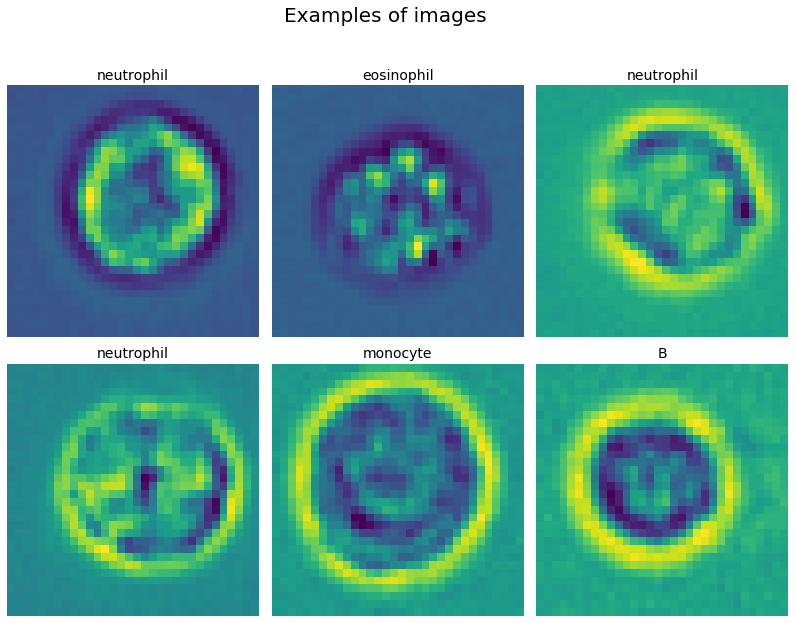

In [5]:
## Let's look at the images - always a good start to the project
# Here random images will be displayed, run this several time to see different images

figure, ax = plt.subplots(2, 3, figsize=(14, 10))
figure.suptitle("Examples of images", fontsize=20)
axes = ax.ravel()

df_images_to_show = df_labels.sample(8)


for i in range(len(axes)):
    row = df_images_to_show.iloc[[i]]
    random_image = Image.open(data_directory + row["Filenames"].values[0])
    axes[i].set_title(row["Class"].values[0], fontsize=14) 
    axes[i].imshow(random_image)
    axes[i].set_axis_off()
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()


### Q: Can you see any difference between the classes? 
### Q: Do you think a human being able to see the difference between classes makes it an easier or more difficult problem for a neural network?

In [6]:
# What's the shape of the image?
image_shape = np.array(random_image).shape
print(image_shape)

(32, 32)


In [7]:
# Let's look a little bit into the labels
set_size = df_labels.size
print(set_size)
print(df_labels.head())

41578
                Filenames Class
0  CRF022_T_1_ch5_106.png     T
1  CRF022_T_1_ch5_119.png     T
2  CRF022_T_1_ch5_123.png     T
3  CRF022_T_1_ch5_128.png     T
4  CRF022_T_1_ch5_134.png     T


In [8]:
df_labels['Class'].value_counts()

neutrophil    4500
monocyte      4303
T             4100
B             4032
eosinophil    3854
Name: Class, dtype: int64

### Question: How many bloodcells of type T is there in the dataset? 

### Question: Next we are going to divide the data into a training, validation and test set. Why do we need 3 sets?

In [9]:
## Next, let's divide the filtered rows into a train, validation and a test set. 
class_column_header = "Class"
df_to_use = df_labels.copy() #We're copying the df_labels so that you can look at it again later if you want

test_set_fraction = 0.1
validation_set_fraction = 0.2



df_test = df_to_use.groupby(class_column_header)
df_test = df_test.apply(lambda _df: _df.sample(frac = test_set_fraction))
df_to_use = pd.concat([df_to_use, df_test, df_test]).drop_duplicates(keep=False) # This line finds the intersection between df_filtered and df_test and df_test and dropps anything that belongs to two of those, so we are left with df_train. Using only df_test once should be fine, but better safe than sorry
df_valid = df_to_use.groupby(class_column_header)
df_valid = df_valid.apply(lambda _df: _df.sample(frac = validation_set_fraction))
df_train = pd.concat([df_to_use, df_valid, df_valid]).drop_duplicates(keep=False) 


In [10]:
print(df_test.head())

                    Filenames Class
20347  CRF102_B_1_ch5_132.png     B
18162   CRF066_B_2_ch5_62.png     B
18461    CRF074_B_2_ch5_3.png     B
20088     CRF59_B_1_ch5_4.png     B
17497  CRF041_B_1_ch5_148.png     B


### Question: How many bloodcells of type T is there in the test dataset?

In [11]:
## Write your code here

# ANN 

Let's set up the basic modle. 

### Q: Why is the input shape the way it is?

In [12]:
## Set up the model architecture
inputs = keras.Input(shape= (32,32,1))
x = layers.Flatten()(inputs)
x = layers.Dense(5, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)


In [13]:
## Define the model as a keras model
ann_model = keras.Model(inputs=inputs, outputs=outputs, name="ann_model")


Next, let's view the model summary to make sure it looks like we expect. Usually we do not count the input layer as a proper layer as it does not contain any parameters nor does anything to the input (it basically *is* the input).

### Question: How many layers do we have?
### Question: How do you get the number of parameters for the output layer? 

## Training

Now that we have our model, all of our parameters are randomized. To make the model better than random we need to train the model. 

### Q: What accuracy do you expect from the first epoch?

### Q: What would be the "best" accuracy you could expect from the network without it having learned anything?

<details>
<summary>
<font size="3" color="green">
<b>My views <code><font size="4">first accuracy</font></code></b>
</font>
</summary>
It is almost impossible to know the accuracy without having done similar things with similar images before, so I would not expect to know at this point.
    
What I would do is calculate what would signify as a random accuracy or the best accuracy possible if the network only guesses at 1 class for all of the images. For 5 classes inuitively it's 20% accuracy, but it will ofcourse depend on the distribution of the classes. If we have 3 classes A, B, and C, and class A has 100 images, B 50 images, and C 50 images, then I'd be causious of a 50% accuracy as the network could simply be guessing class A for every result. 
</details>



For more information on the ImageDataGeneartor see: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [15]:
## Set up generators that specify how the images are loaded, how many at a time (batch size),
## that the images should be shuffled should be shuffled etc.
batch_size = 8

filename_column = 'Filenames'
true_value = "Class"
# create a data generator

## Note: we tend to get better results if the values of the pixels are between 0 and 1, so we need a rescale of 1/255 since the highest possible pixel value for these images are 255
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_valid, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None,class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


train_steps=train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps=valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1



Found 14968 validated image filenames belonging to 5 classes.
Found 3743 validated image filenames belonging to 5 classes.
Found 2078 validated image filenames belonging to 5 classes.


In [16]:
## Compile model
## Don't worry about the details here yet
ann_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])

In [17]:
## Actually train model
## Don't worry about the details here yet

epochs = 5
history = ann_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/5
1871/1871 [==============================] - 29s 16ms/step - loss: 0.7371 - accuracy: 0.7060 - val_loss: 0.5479 - val_accuracy: 0.7947
Epoch 2/5
1871/1871 [==============================] - 16s 9ms/step - loss: 0.4859 - accuracy: 0.8228 - val_loss: 0.4697 - val_accuracy: 0.8375
Epoch 3/5
1871/1871 [==============================] - 17s 9ms/step - loss: 0.4131 - accuracy: 0.8568 - val_loss: 0.4277 - val_accuracy: 0.8472
Epoch 4/5
1871/1871 [==============================] - 20s 11ms/step - loss: 0.3734 - accuracy: 0.8701 - val_loss: 0.4167 - val_accuracy: 0.8568
Epoch 5/5
1871/1871 [==============================] - 21s 11ms/step - loss: 0.3492 - accuracy: 0.8782 - val_loss: 0.4121 - val_accuracy: 0.8613


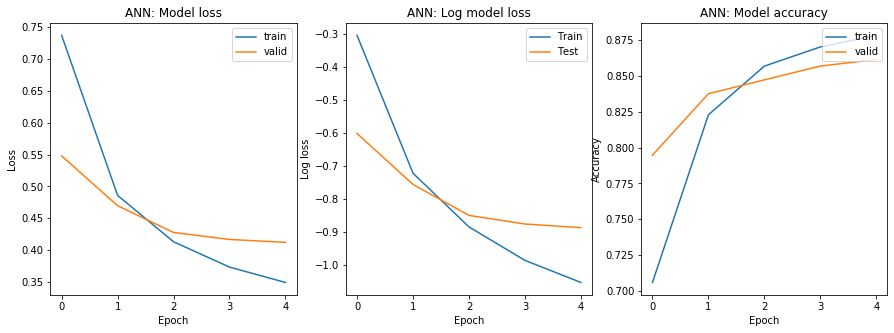

In [18]:
## Plot results
plot_history(history, "ANN")

### Q: How did you do? What do the curves tell you? 


Accuracy: 0.8613411701843441


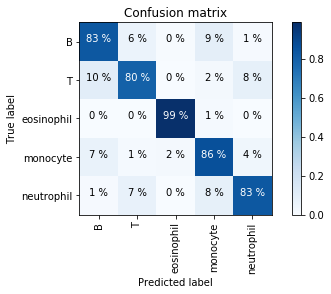

In [20]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model, valid_generator)

### Q: Which class was easiest to predict? Which was the most difficult to predict?

For fun, let's look at the weights in the first dense layer.

In [58]:
cw1 = np.array(ann_model.layers[2].get_weights())
print(cw1.shape) # 2 -> 1 weight, 1 bias
print(cw1[0].shape) # the weights
print(cw1[1].shape) # the biases

(2,)
(1024, 5)
(5,)


Next let's visualize this using the instructions here: https://thispointer.com/python-convert-a-1d-array-to-a-2d-numpy-array-or-matrix/

In [101]:
np_array = np.array(cw1[0])
# Convert 1D array to a 2D numpy array of 2 rows and 3 columns
matrix = np.reshape(np_array, (32, 32,5))
print(matrix.shape)

(32, 32, 5)


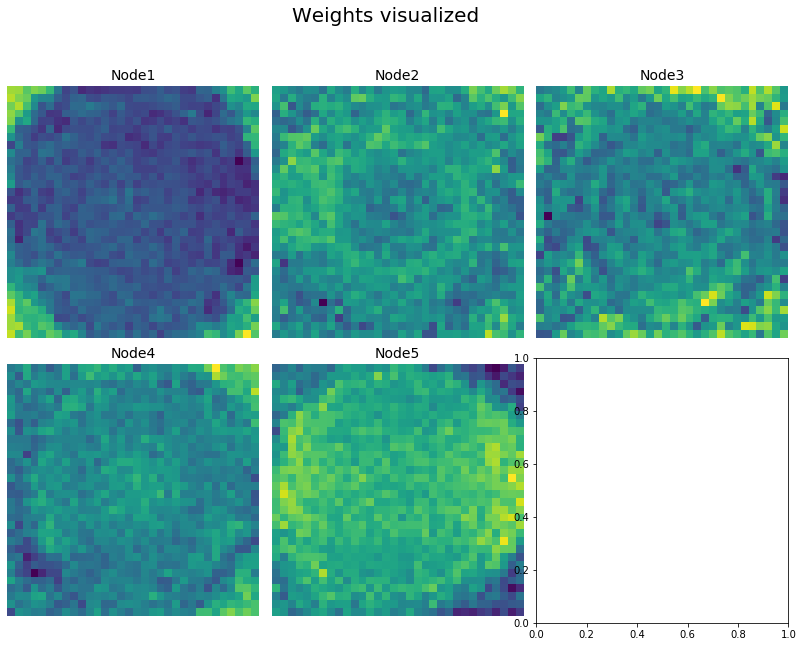

In [112]:
figure, ax = plt.subplots(2, 3, figsize=(14, 10))
figure.suptitle("Weights visualized", fontsize=20)
axes = ax.ravel()

for i in range(0,5):
    image = matrix[:,:,i:i+1]
    image = image[:,:,0]
    axes[i].set_title("Node" + str(i+1), fontsize=14) 
    axes[i].imshow(image)
    axes[i].set_axis_off()
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

## Expanding the model

### Add another dense layer, making it so that the new layer after the input layer has 10 nodes

### Q: How many paramters will this new layer have?
### Q: How will this affect how many parameters the last layer has? Why?

In [23]:
## Set up the model architecture
inputs = keras.Input(shape= (32,32,1))
x = layers.Flatten()(inputs)
x = layers.Dense(5, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)

In [24]:
## Define the model as a keras model
ann_model_2 = keras.Model(inputs=inputs, outputs=outputs, name="ann_model")


In [25]:
ann_model_2.summary()

Model: "ann_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
Total params: 5,155
Trainable params: 5,155
Non-trainable params: 0
_________________________________________________________________


In [26]:
## Compile model
## Don't worry about the details here yet
ann_model_2.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])

In [27]:
## Actually train model
## Don't worry about the details here yet

epochs = 5
history = ann_model_2.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/5
1871/1871 [==============================] - 28s 15ms/step - loss: 0.6753 - accuracy: 0.7291 - val_loss: 0.5387 - val_accuracy: 0.7910
Epoch 2/5
1871/1871 [==============================] - 15s 8ms/step - loss: 0.4788 - accuracy: 0.8218 - val_loss: 0.4740 - val_accuracy: 0.8271
Epoch 3/5
1871/1871 [==============================] - 16s 8ms/step - loss: 0.4075 - accuracy: 0.8569 - val_loss: 0.4455 - val_accuracy: 0.8490
Epoch 4/5
1871/1871 [==============================] - 19s 10ms/step - loss: 0.3735 - accuracy: 0.8689 - val_loss: 0.4379 - val_accuracy: 0.8568
Epoch 5/5
1871/1871 [==============================] - 20s 11ms/step - loss: 0.3494 - accuracy: 0.8792 - val_loss: 0.4198 - val_accuracy: 0.8533


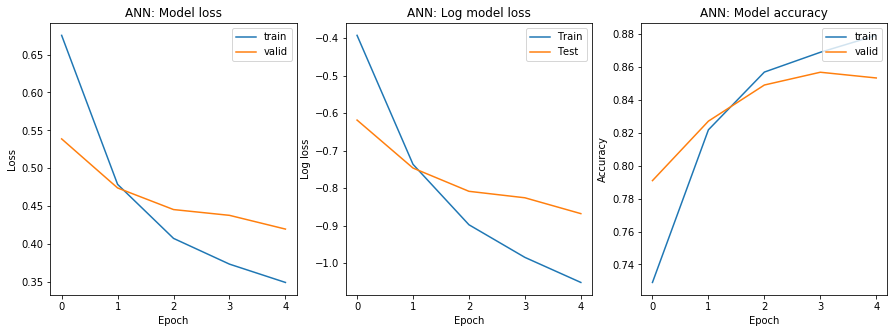

In [28]:
## Plot results
plot_history(history, "ANN")

Accuracy: 0.8533262089233236


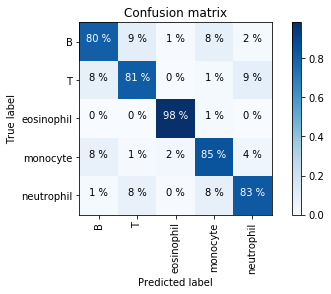

In [29]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model_2, valid_generator)

## Try another model: add whatever size dense layer you like to your best model from above

In [31]:
## Set up the model architecture
inputs = keras.Input(shape= (32,32,1))
x = layers.Flatten()(inputs)
x = layers.Dense(5, activation="relu")(x)
outputs = layers.Dense(5, activation="softmax")(x)

In [36]:
## Define the model as a keras model
ann_model_3 = keras.Model(inputs=inputs, outputs=outputs, name="ann_model")


In [37]:
ann_model_3.summary()

Model: "ann_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 5125      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
Total params: 5,155
Trainable params: 5,155
Non-trainable params: 0
_________________________________________________________________


In [41]:
## Compile model
## Don't worry about the details here yet
ann_model_3.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])

In [42]:
## Actually train model
## Don't worry about the details here yet

epochs = 5
history = ann_model_3.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/5
1871/1871 [==============================] - 28s 15ms/step - loss: 0.7904 - accuracy: 0.6879 - val_loss: 0.6033 - val_accuracy: 0.7695
Epoch 2/5
1871/1871 [==============================] - 17s 9ms/step - loss: 0.5325 - accuracy: 0.7985 - val_loss: 0.5165 - val_accuracy: 0.8268
Epoch 3/5
1871/1871 [==============================] - 16s 9ms/step - loss: 0.4535 - accuracy: 0.8376 - val_loss: 0.5077 - val_accuracy: 0.8209
Epoch 4/5
1871/1871 [==============================] - 20s 10ms/step - loss: 0.4115 - accuracy: 0.8558 - val_loss: 0.4693 - val_accuracy: 0.8359
Epoch 5/5
1871/1871 [==============================] - 21s 11ms/step - loss: 0.3813 - accuracy: 0.8673 - val_loss: 0.4479 - val_accuracy: 0.8485


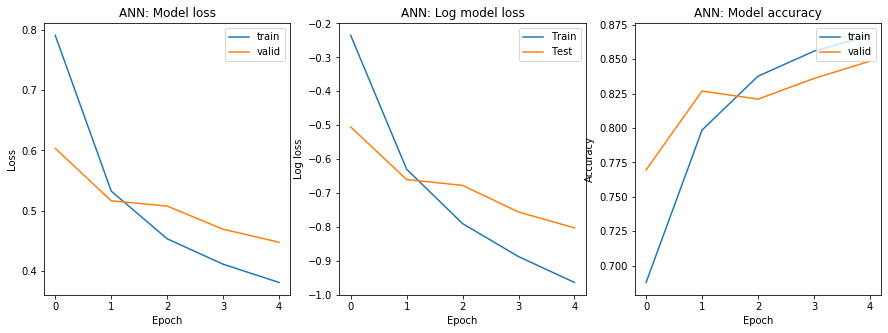

In [43]:
## Plot results
plot_history(history, "ANN")

Accuracy: 0.8482500667913438


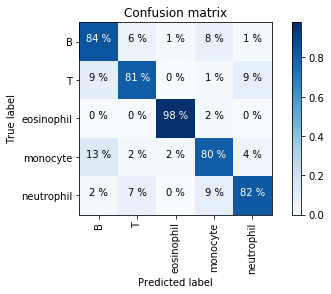

In [45]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model_3, valid_generator)

## Train your best model for more epochs. 

### Q: What do you expect to happen with the accuracy as you train for more epochs?

In [46]:
## Actually train model
## Don't worry about the details here yet

epochs = ## Increase
history = ann_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

SyntaxError: invalid syntax (<ipython-input-46-d4b617c51c89>, line 4)

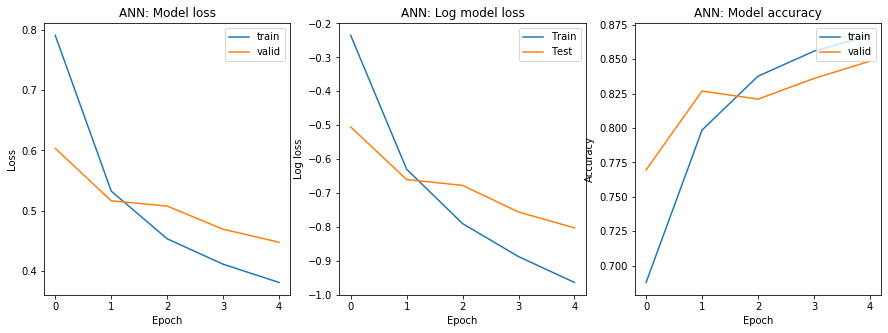

In [47]:
## Plot results
plot_history(history, "ANN")

Accuracy: 0.8482500667913438


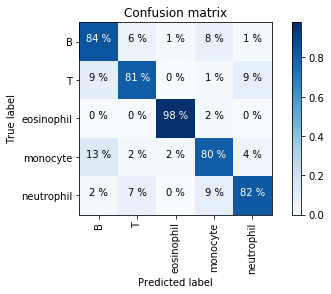

In [48]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model_3, valid_generator)

# CNN

Next, let's make a CNN
We'll use the same data, but apply convolutions instead of only dense layers.

### Q: What are the biggest differences between how an ANN and a CNN treats the data?

In [113]:
## Set up the model architecture
# See https://www.tensorflow.org/guide/keras/functional/ if you want to see the documentation

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(1, kernel_size=(3, 3), strides=1,padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

In [114]:
## Define the model as a keras model
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_1")

In [115]:
## We'll use the same generators as above here, so no need to redefine them
## compile model

cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 1)         5         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 1285      
Total params: 1,290
Trainable params: 1,290
Non-trainable params: 0
_________________________________________________________________


In [116]:
## Actually train model
epochs = 5
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/5
1871/1871 [==============================] - 29s 16ms/step - loss: 0.8833 - accuracy: 0.6539 - val_loss: 0.6475 - val_accuracy: 0.7736
Epoch 2/5
1871/1871 [==============================] - 15s 8ms/step - loss: 0.6069 - accuracy: 0.7732 - val_loss: 0.6257 - val_accuracy: 0.7776
Epoch 3/5
1871/1871 [==============================] - 14s 7ms/step - loss: 0.5636 - accuracy: 0.7879 - val_loss: 0.5598 - val_accuracy: 0.8043
Epoch 4/5
1871/1871 [==============================] - 16s 9ms/step - loss: 0.5395 - accuracy: 0.7998 - val_loss: 0.5962 - val_accuracy: 0.7666
Epoch 5/5
1871/1871 [==============================] - 20s 11ms/step - loss: 0.5261 - accuracy: 0.8087 - val_loss: 0.5643 - val_accuracy: 0.7923


In [ ]:
## Plot results
plot_history(history, "CNN")

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

### What networked performed best for you? Did the results differ for any of the classes between the ANN and CNN?



<details>
<summary>
<font size="3" color="green">
<b>Expand this after answering the questions above<code><font size="4">ANN vs CNN</font></code></b>
</font>
</summary>
Likely the ANN outperformed the CNN. Usually we expect a convolutional neural network to perform better than a non-conformal neural network with images. This is because images are *atleast* 2D structures, and information can be in many places in the images. Why then did the ANN outperform the CNN in this case? Think about the data, does the placement of the information vary a lot in the images?    
    
    Another thing to consider: How many parameters did you have in the ANN compared to the C
</details>

# Expanding the models

## Deeper models


Sometimes a deeper model and/or a more complex model, can be helpful. Try adding some more convolution layers and pooling layers to the model. Try changing the filter sizes, and the number of filters as well.
More information about the convolutional layer can be found here: https://keras.io/api/layers/convolution_layers/convolution2d/, maxpooling here: https://keras.io/api/layers/pooling_layers/max_pooling2d/, and a different kind of way of making models can be found here: https://www.tensorflow.org/tutorials/images/cnn  and here https://www.tensorflow.org/tutorials/quickstart/advanced

In [131]:
## Set up the model architecture

#Change the code below so that the new model has roughly the same number of parameters as your best ANN
# Hint: you can add both more Conc2D layers, and increase the kernel (filter) size

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(5, kernel_size=(3, 3), strides=1,padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_2")

## Compile the model
cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

Model: "cnn_Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 5)         25        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 5)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 6405      
Total params: 6,430
Trainable params: 6,430
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## Actually train model
epochs = 10
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
                                 )         

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1871 steps, validate for 467 steps
Epoch 1/10
1871/1871 [==============================] - 29s 15ms/step - loss: 0.3816 - accuracy: 0.8681 - val_loss: 0.2734 - val_accuracy: 0.9221
Epoch 2/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.2124 - accuracy: 0.9289 - val_loss: 0.2462 - val_accuracy: 0.9299
Epoch 3/10
1871/1871 [==============================] - 15s 8ms/step - loss: 0.1862 - accuracy: 0.9401 - val_loss: 0.2497 - val_accuracy: 0.9304
Epoch 4/10
1871/1871 [==============================] - 17s 9ms/step - loss: 0.1665 - accuracy: 0.9431 - val_loss: 0.2358 - val_accuracy: 0.9307
Epoch 5/10
 930/1871 [=============>................] - ETA: 8s - loss: 0.1607 - accuracy: 0.9435

In [ ]:
## Plot results
plot_history(history, "cnn_model")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

## Try a couple of deeper models and save your best one for further study


#### HINT: You can comment out a whole cell by selecting all and then do ctr + / or cmnd + / 
#### You can then add another cell with the + button next to the save button at the top of this notebook's tool bar.
#### You can of course also keep adding cells and copying all the relevant code, making and saving new models. Whatever is easiest for you is best here.

## Data Augmentation


Let's try something else, maybe you would like to add some data augmentation? 
Data augmentation basically means that we randomly alter the incoming images in different ways to make sure that the network can handle those types of variations.

If you want to read more you can look at this article, especially the "Data Augmentations based on basic image manipulations Geometric transformations" is of interest here: https://journalofbigdata.springeropen.com/articles/10.1186/s40537-019-0197-0

See https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator for things you can try by adding input paramters to the ImageDataGenerator().


Update the cell below to  **include data augmentations, only in the training data generator then run your CNN again**

In [ ]:
## Set up generators 
batch_size = 8

filename_column = 'Filenames'
true_value = "Class"
# create a data generator

## Note: we tend to get better results if the values of the pixels are between 0 and 1, so we need a rescale of 1/255 since the highest possible pixel value for these images are 255
train_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True ,## ADD CODE HERE)
valid_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)
test_data_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255, samplewise_center=True, samplewise_std_normalization=True)

train_generator = train_data_generator.flow_from_dataframe(
    df_train, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' ,shuffle=True,
)

valid_generator = valid_data_generator.flow_from_dataframe(
    df_valid, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None, class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


test_generator = test_data_generator.flow_from_dataframe(
    df_test, directory=data_directory, x_col=filename_column, y_col=true_value,
    weight_col=None,class_mode='categorical', batch_size=batch_size, target_size = image_shape,  color_mode='grayscale' , shuffle=False,
)


train_steps=train_generator.n//train_generator.batch_size if train_generator.n >= train_generator.batch_size else 1
validation_steps=valid_generator.n//valid_generator.batch_size if valid_generator.n >= valid_generator.batch_size else 1


In [ ]:
## Set up the model architecture
### use your best model from above, and rename it here to cnn_model_augmented
cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(1, kernel_size=(3, 3), strides=2,padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)

In [ ]:
## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model_2")

In [ ]:
## Compile the model

cnn_model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
cnn_model.summary()

In [ ]:
## Actually train model
epochs = 10
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

In [ ]:
## Plot results
plot_history(history, "Data Augmentation added")

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

### Q: Did the data augmentation help? Why or why not? What makes this dataset more or less likely to be helped by data augmentation?


<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">question above</font></code></b>
</font>
</summary>
    1. Are the blood cells at random places in the image?
    
2. Look at some of the images. Are the bloodcells centered? What could rotations or zooms change about this?
    
3. Are there color changes you could compensate for?    
</details>

## Regularisation methods


Both BatchNormalization and DropOut are two different regularisation methods. Try adding both to the best working CNN model.  
  
Read more about BatchNormalization here: https://keras.io/api/layers/normalization_layers/batch_normalization/
Read more about DropOut here:https://keras.io/api/layers/regularization_layers/dropout/

### Q:  What are the main similarities and differences between these methods?

In [ ]:

# Create the model here
## Set up the model architecture
### use your best model from above

cnn_inputs = keras.Input(shape=(32,32,1))
x = layers.Conv2D(1, kernel_size=(3, 3), strides=2,padding='same')(cnn_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)
cnn_outputs = layers.Dense(5, activation='softmax')(x)





In [ ]:
## Define the model 
cnn_model = keras.Model(inputs=cnn_inputs, outputs=cnn_outputs, name="cnn_Model")

In [ ]:
## Compile the model

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
## Actually train model
epochs = 15
history = cnn_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

In [ ]:
## Plot results
plot_history(history, "test_Name")

# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(cnn_model, valid_generator)

### Q: Is there such a thing as too much regularisation?

# Visualise your best CNN

Use the code below to visualise some of the weights you have trained. Hint: Weights are present in convolutional filters and dense layers, nowhere else

In [128]:
# Pick the layer 
print(cnn_model.layers)
cw1 = np.array(cnn_model.layers[1].get_weights()) ## Pick the layer whose weights you want to visualise
print(cw1.shape) # 2 weight, 1 weight, 1 bias
print(cw1[0].shape) # Weights
print(cw1[1].shape) # Biases
matrix = cw1[0]

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fbb7815efd0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fbb78173320>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7fbb781734e0>, <tensorflow.python.keras.layers.core.Flatten object at 0x7fbb78185e10>, <tensorflow.python.keras.layers.core.Dense object at 0x7fbb4037a898>]
(2,)
(2, 2, 1, 1)
(1,)


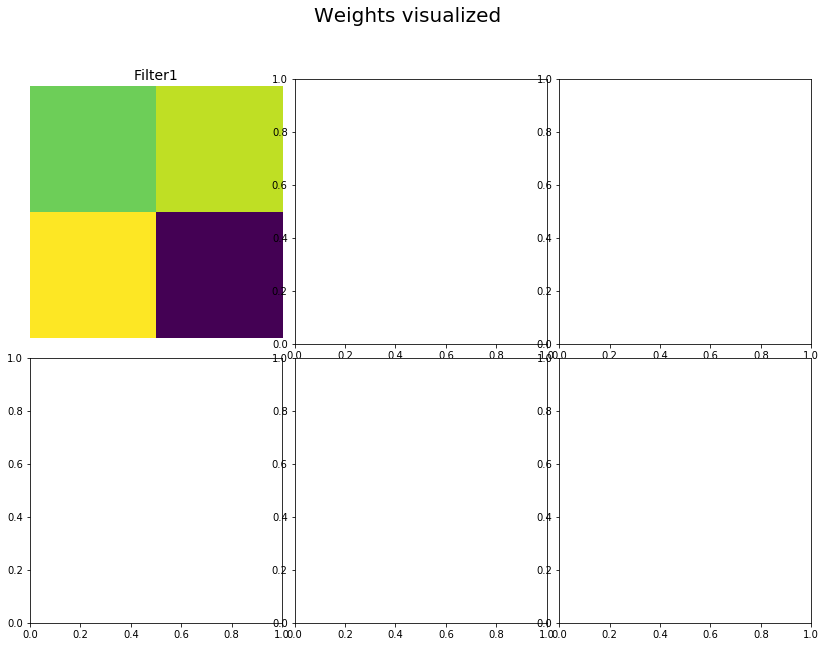

In [130]:
# Plot your filters 
figure, ax = plt.subplots(2, 3, figsize=(14, 10))
figure.suptitle("Weights visualized", fontsize=20)
axes = ax.ravel()

for i in range(0,1): # Range should be 0 - the number of filters you have
    image = matrix[:,:,i:i+1]
    image = np.reshape(matrix, (2, 2)) ## Reshape to the size of your filters
    axes[i].set_title("Filter" + str(i+1), fontsize=14) 
    axes[i].imshow(image)
    axes[i].set_axis_off()
    
plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()
plt.close()

# Using existing models 

One great thing to do when making a CNN model is to use an architecture that has worked for simmilar cases. I happen to know that the existing CNN model VGG16 is a good model for these types of images, try that one next.

There are many way of visualising neural networks, see https://datascience.stackexchange.com/questions/12851/how-do-you-visualize-neural-network-architectures, but here is one made by Christophe Avenel

<img src="Illustrations/vgg16.png" title="VGG16 model"/>

### VGG16

In [ ]:
vgg_model = keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_shape=(32, 32, 1),
    pooling=None,
)


In [ ]:

# add new classifier layers
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
class1 = layers.Dense(1024, activation='relu')(flat1)
output = layers.Dense(5, activation='softmax')(class1)


In [ ]:

vgg_model = keras.Model(inputs=vgg_model.inputs, outputs=output)

print (vgg_model.summary())

### Q: How many parameters does this model have?

In [ ]:
## Compile the model

vgg_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

### Q: Why do we need a new classification layers?

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">question above</font></code></b>
</font>
</summary>
1. What is the original network classifying? 

2. What do we want to classify? 
    
<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">The hint, if you need it</font></code></b>
</font>
</summary>
1. So how do we remove the previous classification and make the new one? Just like the code above naturally! A flattening layer is almost always followed by a dense layer or two to expand the model, and then a final classification layer.
    

</details>
</details>

In [ ]:
## Actually train model
epochs = 10
history = vgg_model.fit_generator(generator=train_generator,
                    steps_per_epoch= train_steps,
                    validation_data= valid_generator,
                    validation_steps= validation_steps,
                    epochs= epochs
        )

In [ ]:
## Plot results
plot_history(history, "VGG16")

In [ ]:
# plot confusion matrix
cnn_helper.plot_confusion_matrix_from_generator(ann_model, valid_generator)

### Q: What is your worst performing class in this classifier? Is it the same as in the other ones?

### Q: How many layers with 10 filters of size 3*3 would you have to add to the first CNN model we designed to achieve the same number of parameters?  

# Finally test your best model

In [ ]:
test_steps=test_generator.n//test_generator.batch_size if test_generator.n >= test_generator.batch_size else 1

pred=unknown_model.predict_generator(test_generator, ## replace unknown_model with your best model
steps=test_steps,
verbose=1)

In [ ]:
cnn_helper.plot_confusion_matrix_from_generator(unknown_model, test_generator) ## replace unknown_model with your best model

  
  
  
## The lab is done! Good job getting this far, and understanding what you are doing!  

## Now you have the opportunity to look at some other interesting things: there is another notebook that focusing on segmentation instead of classification, or you can continue improving your "standard" models according to the suggestions below.
  
    
    

# Optional

Try other optimizers, learning rates, batch sizes or number of epochs. Which would you like to try first and why?

# Optional

Try and make a neural network with no convolutions that perform as well as the VGG16.

## Optional

Try using different proportions for training, validation and test. How does this affect your results? Why?